In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

In [2]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [3]:
dataset = ImageFolder('data/samples', transform=transform)

In [4]:
dataset.classes

['Active_Eyes', 'Fatigue_Eyes']

In [5]:
# split dataset into train and test

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

len(train_dataset), len(test_dataset)

(928, 233)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

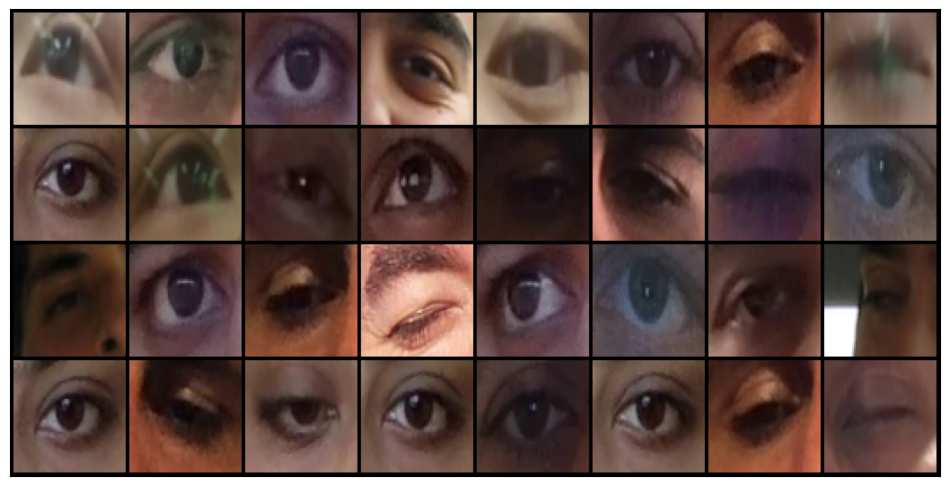

In [7]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


show_batch(train_loader)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EyeClassifier(nn.Module):
    def __init__(self):
        super(EyeClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.classifier(x)
        return x

model = EyeClassifier()

In [9]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(model, criterion, optimizer, train_loader, test_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch: {epoch+1}, Loss: {running_loss / i}")
    print("Finished Training")


train(model, criterion, optimizer, train_loader, test_loader, epochs=5)

Epoch: 1, Loss: 0.7170906620366233
Epoch: 2, Loss: 0.6360560485294887
Epoch: 3, Loss: 0.422780908112015
Epoch: 4, Loss: 0.33233909202473505
Epoch: 5, Loss: 0.3113849695239748
Finished Training


In [10]:

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels.float().view(-1, 1)).sum().item()
    print(f"Accuracy: {100 * correct / total}")


evaluate(model, test_loader)

Accuracy: 88.41201716738198


In [11]:
# Save the model
torch.save(model.state_dict(), "eye_classifier.pth")

In [12]:
# Load the model
model = EyeClassifier()
model.load_state_dict(torch.load("eye_classifier.pth"))
model

EyeClassifier(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)